In [128]:
import pandas as pd
import numpy as np
import spacy
from textblob import TextBlob
from transformers import pipeline
import re
import string
from wordcloud import WordCloud,STOPWORDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec


In [2]:
# you have to pip install wordcloud, transformers, spacy, and  pretrained models 
#need to have pytorch installed on your system


#pip install transformers
#git lfs install
#git clone https://huggingface.co/oliverguhr/german-sentiment-bert
#git clone https://huggingface.co/savasy/bert-base-turkish-sentiment-cased

#read documentation here: https://huggingface.co/transformers/quicktour.html
#https://huggingface.co/savasy/bert-base-turkish-sentiment-cased#
#https://huggingface.co/oliverguhr/german-sentiment-bert?text=I+like+you.+I+love+you#


In [3]:
#model for sentiment analysis in turkish language

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_tr = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

model_tr = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

turkish= pipeline("sentiment-analysis", tokenizer=tokenizer_tr, model=model_tr)

In [4]:
#example

t = turkish("bu telefon modelleri çok kaliteli , her parçası çok özel bence")
print(t)
# [{'label': 'LABEL_1', 'score': 0.9871089}]
# print(p[0]['label'] == 'LABEL_1')
# True
t[0]['label']

[{'label': 'positive', 'score': 0.983146607875824}]


'positive'

In [5]:
#model in english language

english = pipeline('sentiment-analysis')

#example
e=english("Hey, you are beautiful")

e

[{'label': 'POSITIVE', 'score': 0.999866783618927}]

In [6]:
#model in german language
tokenizer_gr = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")

model_gr = AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert")

german= pipeline("sentiment-analysis", tokenizer=tokenizer_gr, model=model_gr)

#example

g=german("Ich liebe dich")

g[0]['score']

0.9846150875091553

In [180]:
#define functions to get sentiment and scores in differnt languages using different models

def sentiment_tr(text_list):
    sentence=' '.join(word for word in text_list)
    sentiment=turkish(sentence)[0]['label']
    return sentiment

def sentiment_score_tr(text_list):
    sentence=' '.join(word for word in text_list)
    score=turkish(sentence)[0]['score']
    return score


def sentiment_gr(text_list):
    sentence=' '.join(word for word in text_list)
    sentiment=german(sentence)[0]['label']
    return sentiment

def sentiment_score_gr(text_list):
    sentence=' '.join(word for word in text_list)
    score=german(sentence)[0]['score']
    return score


def sentiment_en(text_list):
    sentence=' '.join(word for word in text_list)
    sentiment=english(sentence)[0]['label']
    return sentiment

def sentiment_score_en(text_list):
    sentence=' '.join(word for word in text_list)
    score=english(sentence)[0]['score']
    return score
    

In [8]:
#stopwords. We chose stopwords from spacy because it has more stopwords than nltk and also has turkish stopwords

from spacy.lang.en.stop_words import STOP_WORDS as stopwords_english
from spacy.lang.de.stop_words import STOP_WORDS as stopwords_deutsch
from spacy.lang.tr.stop_words import STOP_WORDS as stopwords_turkish

In [9]:
stop_words=list(stopwords_english)+list(stopwords_deutsch)+list(stopwords_turkish)

more_stopwords=['erdoÄŸan','merkel','modi','bjp','cdp','akp','hÃ¼kÃ¼met','gsyä°h','government','govt','regierung','wirtschaft',
                'corona','covid','economy','ekonomi','keyword']

stop_words=stop_words+ more_stopwords
print(stop_words)


['several', 'i', 'alone', 'however', 'further', '‘d', 'hundred', 'still', "'ll", 'which', 'thence', 'now', 'in', 'nor', 'nothing', 'before', 'among', 'else', 'were', 'your', 'he', 'together', 'keep', 'on', 'also', 'front', 'anyway', 'take', 'until', 'everyone', 'my', 'onto', 'upon', 'part', 'me', 'nobody', 'being', 'should', 'seemed', 'across', 'everywhere', 'him', 'get', 'below', 'doing', 'made', 'amount', '’m', 'as', 'and', 'ever', 'thereupon', 'am', 'seeming', 'other', 'no', 'against', 'two', 'four', 'nevertheless', 'last', 'formerly', 'above', 'an', 'otherwise', 'such', 'us', 'hence', 'either', 'whither', 'than', 'again', 'herein', 'put', 'then', 'why', 'go', 'could', 'more', 'between', 'someone', 'say', 'n‘t', 'sixty', 'side', 'hereupon', 'none', '‘re', 'she', 'while', 'a', 'become', '’ve', 'only', 'becomes', 'whole', 'whose', 'under', 'back', 'do', 'hers', 'thereafter', 'eleven', 'per', '‘ll', 'the', 'will', 'whence', 'whoever', 'ten', 'done', 'to', 'over', 'their', 'although', '

In [10]:
#load csv file

df=pd.read_csv('C:\\Users\\mayan\\OneDrive\\Documents\\Dataset\\Data_set.csv',encoding='utf-8')

In [11]:
df.sample(3)

,tweet,timestamp,city,keyword
22541,"Donald Trump, covid-19'a Ã‡in virÃ¼sÃ¼ diyordu...",04-01-2021 23:12,Ankara,covid
21937,Moroccoâ€™s blue-hued Chefchaouen emptied by C...,05-01-2021 09:45,Istanbul,covid
13739,The GDP growth rate has fallen steeply over th...,02-01-2021 14:31,Chennai,GDP


In [181]:
#define a function to add a country column

def country(city):
    city=city.lower()
    if (city=='berlin'or city=='munich' or city=='hamburg' or city=='cologne'):
        country= 'Germany'
    elif (city=='delhi'or city=='mumbai'or city=='chennai'or city=='kolkata'):
        country='India'
    else:
        country='Turkey'
    return country


def categories(key):
    key=key.lower()
    if (key=='economy'or key=='ekonomi' or key=='gdp' or key=='gsyä°h' or key=='bip'or key=='wirtschaft'):
        category= 'Economy'
    elif (key=='covid'or key=='corona'):
        category='Govt Handling Of Pandemic'
    elif (key=='hã¼kã¼met'or key=='regierung'):
        category='Government'
    elif (key=='modi'):
        category='Modi'
    elif (key=='erdoÄŸan'or key=='erdoäÿan'):
        category='Erdogan'
    elif (key=='merkel'):
        category='Merkel'
    else:
        category=key
    return category



categories('hã¼kã¼met')

'Government'

In [144]:
'hÃ¼kÃ¼met'.lower()

'hã¼kã¼met'

In [13]:
df['country']=df['city'].apply(country)
df.sample(3)

,tweet,timestamp,city,keyword,country
10632,@_TheEnigmous After lockdown those who used to...,04-01-2021 17:24,Kolkata,BJP,India
453,Angela Merkel: Die nackte dumme Kaiserin #merk...,05-01-2021 05:55,Munich,Merkel,Germany
1819,Die Kanzlerin holt am Mittwoch die Fachministe...,05-01-2021 13:43,Berlin,Regierung,Germany


In [14]:
#add a new column which contains list of words (in lower case) in tweet without stopwords


df['list_of_words']=df['tweet'].apply(lambda x: [word.lower() for word in x.split() if word.lower() not in stop_words])

In [15]:
df.sample(3)

,tweet,timestamp,city,keyword,country,list_of_words
19016,@CanGokce5 Akademisyene asgari Ã¼cretin iki ka...,29-12-2020 09:55,Antalya,AKP,Turkey,"[@cangokce5, akademisyene, asgari, ã¼cretin, i..."
21969,Thailand reports 527 new cases of Covid-19 inc...,05-01-2021 05:46,Istanbul,covid,Turkey,"[thailand, reports, 527, new, cases, covid-19,..."
13603,@pallavict Waiting for the GDP growth rate num...,01-01-2021 12:18,Mumbai,GDP,India,"[@pallavict, waiting, gdp, growth, rate, numbe..."


In [16]:
#define function to remove noise

def clean_text(text_list):
    for text in text_list:
        text = re.sub(r'@[a-zA-Z0-9_]+','',text)
        text = re.sub(r'#','',text)
        text = re.sub(r'rt[\s]+','',text)
        text = re.sub(r'https?:\/\/\s+','',text)
        text = re.sub(r'timestamp|keyword|tweets|geocode|modi|merkel|erdogan|tayyip','',text)
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = re.sub('[‘’“”…]', '', text)
#     translator = google_translator()
#     text=translator.translate(text,lang_tgt='en')
    
    
    return text_list

In [18]:
df['list_of_words']=df['list_of_words'].apply(clean_text)

In [19]:
df.sample(4)

,tweet,timestamp,city,keyword,country,list_of_words
14790,@RubikaLiyaquat Sir mere papa ko v corona hai ...,03-01-2021 16:54,Kolkata,corona,India,"[@rubikaliyaquat, sir, mere, papa, ko, v, hai,..."
8862,@ABPNews @singhanjali 26 january nazdeek hai.....,04-01-2021 19:15,Delhi,Modi,India,"[@abpnews, @singhanjali, 26, january, nazdeek,..."
15310,TOP 8 DATA BREACHES that happened during COVID...,04-01-2021 20:49,Delhi,covid,India,"[8, data, breaches, happened, pandemic, -, lis..."
10323,Which is not surprising considering BJP is 420...,04-01-2021 16:24,Chennai,BJP,India,"[surprising, considering, 420!, https://t.co/i..."


In [20]:
#remove usernames starting with '@' and links
def clean_more(text_list):
    words=[]
    for word in text_list:
        if (word.startswith('@')==False and word.startswith('https')==False):
            words.append(word)
    return words

In [21]:
df['list_of_words']=df['list_of_words'].apply(clean_more)

In [22]:
df.sample(4)

,tweet,timestamp,city,keyword,country,list_of_words
10804,à¦†à¦¸à¦¾à¦¨à¦¸à§‹à¦²à§‡ à¦¬à¦¿à¦œà§‡à¦ªà¦¿ à¦...,04-01-2021 09:10,Kolkata,BJP,India,"[à¦†à¦¸à¦¾à¦¨à¦¸à§‹à¦²à§‡, à¦¬à¦¿à¦œà§‡à¦ªà¦¿,..."
13249,Covid 19 hit to GDP of various countries. Usef...,04-01-2021 03:48,Delhi,GDP,India,"[19, hit, gdp, countries., useful, chart, gold..."
4992,Wirtschaft in Deutschland 2021 - Luftfahrt: Di...,02-01-2021 12:08,Hamburg,Wirtschaft,Germany,"[deutschland, 2021, -, luftfahrt:, hoffnung, s..."
5004,Deutschland kann sich den Lockdown und die Ãœb...,02-01-2021 10:54,Hamburg,Wirtschaft,Germany,"[deutschland, lockdown, ãœberbrã¼ckungsgelder,..."


In [23]:
#create separate dataframes for turkey, india and germany

df_germany=df[df['country']=='Germany']
df_turkey=df[df['country']=='Turkey']
df_india=df[df['country']=='India']

In [24]:
df_turkey.sample(2)

,tweet,timestamp,city,keyword,country,list_of_words
22485,@A101iletisim yazÄ±klar olsun size. 26 AralÄ±k...,05-01-2021 10:43,Ankara,covid,Turkey,"[yazä±klar, size., 26, aralä±k, verdiäÿim, sip..."
23284,BÃ¼yÃ¼k gurur ðŸ§¿\n#turkey\n#tÃ¼rkiye\n#covid...,02-01-2021 15:49,Antalya,covid,Turkey,"[bã¼yã¼k, gurur, ðÿ§¿, #turkey, #tã¼rkiye, #co..."


In [178]:
#add clolumns for sentiment and score for turkish, german and indian dataframe using the functions and models defined above
df_turkey['sentiment']=df_turkey.iloc[:,-1].apply(sentiment_tr)
df_turkey['score']=df_turkey.iloc[:,-2].apply(sentiment_score_tr)

df_germany['sentiment']=df_germany.iloc[:,-1].apply(sentiment_gr)
df_germany['score']=df_germany.iloc[:,-2].apply(sentiment_score_gr)

df_india['sentiment']=df_india.iloc[:,-1].apply(sentiment_en)
df_india['score']=df_india.iloc[:,-2].apply(sentiment_score_en)

KeyboardInterrupt: 

In [26]:
#the score signifies the confidence of label (positive , negative or neutral)

df_india

,tweet,timestamp,city,keyword,country,list_of_words,sentiment,score
8856,@ExSecular @Proud_Hindu_PS @kavita_krishnan Ja...,04-01-2021 19:28,Delhi,Modi,India,"[jack, ma, missing, reportedly, criticising, c...",NEGATIVE,0.990193
8857,Jack Ma missing after reportedly criticising C...,04-01-2021 19:28,Delhi,Modi,India,"[jack, ma, missing, reportedly, criticising, c...",NEGATIVE,0.991199
8858,@DrNaseemAhmedS1 @SufiyanSRK22 @ramavtar5542 @...,04-01-2021 19:25,Delhi,Modi,India,"[kar, di, zahil, wali, baat, google, se, kya, ...",NEGATIVE,0.991148
8859,@KanganaTeam @diljitdosanjh Modi ki chaatne se...,04-01-2021 19:18,Delhi,Modi,India,"[chaatne, se, tuje, bi, followers, nhi, milege...",NEGATIVE,0.975084
8860,"The cause of Killer modi corrupt,. Christian C...",04-01-2021 19:17,Delhi,Modi,India,"[cause, killer, corrupt,., christian, congress]",NEGATIVE,0.995473
...,...,...,...,...,...,...,...,...
16113,à¤‡à¤‚à¤¡à¤¿à¤¯à¤¾ à¤²à¤¿à¤¸à¥à¤Ÿ à¤‘à¤« à¤•...,04-01-2021 04:09,Kolkata,covid,India,"[à¤‡à¤‚à¤¡à¤¿à¤¯à¤¾, à¤²à¤¿à¤¸à¥à¤ÿ, à¤‘à¤«, ...",NEGATIVE,0.971953
16114,Is it cluster days of Covid Positive back? ..T...,04-01-2021 04:05,Kolkata,covid,India,"[cluster, days, positive, back?, ..tm]",NEGATIVE,0.710812
16115,India and Australia players and staff all test...,04-01-2021 03:58,Kolkata,covid,India,"[india, australia, players, staff, test, negat...",NEGATIVE,0.995639
16116,à¦…à¦¤à¦¿à¦®à¦¾à¦°à§€ à¦†à¦¬à¦¹à§‡ à¦•à§‹à¦­à¦...,04-01-2021 03:58,Kolkata,covid,India,"[à¦…à¦¤à¦¿à¦®à¦¾à¦°à§€, à¦†à¦¬à¦¹à§‡, à¦•à§‹à¦...",NEGATIVE,0.976360


In [182]:
dataframes=[df_india,df_turkey,df_germany]

    

df_india['Category']=df_india['keyword'].apply(categories)
df_turkey['Category']=df_turkey['keyword'].apply(categories)
df_germany['Category']=df_germany['keyword'].apply(categories)

df_india.to_csv("Indien2021.csv", encoding="utf-8")
df_turkey.to_csv("turkiye2021.csv", encoding="utf-8")
df_germany.to_csv("germania2021.csv", encoding="utf-8")



<ipython-input-182-21f4678c029c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_india['Category']=df_india['keyword'].apply(categories)
<ipython-input-182-21f4678c029c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_turkey['Category']=df_turkey['keyword'].apply(categories)
<ipython-input-182-21f4678c029c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [183]:
df_turkey

,tweet,timestamp,city,keyword,country,list_of_words,sentiment,score,Category
8855,Tweets,Timestamp,Location,Keyword,Turkey,[tweets],positive,0.994093,keyword
16118,Tweets,Timestamp,Location,Keyword,Turkey,[tweets],positive,0.994093,keyword
16119,CumhurbaÅŸkanÄ± ErdoÄŸan'dan Fethi Sekin Payla...,05-01-2021 18:56,Istanbul,ErdoÄŸan,Turkey,"[cumhurbaåÿkanä±, erdoäÿan'dan, fethi, sekin, ...",positive,0.967817,Erdogan
16120,"#Arnavutluk Cumhuriyeti BaÅŸbakanÄ± Edi Rama, ...",05-01-2021 18:54,Istanbul,ErdoÄŸan,Turkey,"[#arnavutluk, cumhuriyeti, baåÿbakanä±, edi, r...",positive,0.862912,Erdogan
16121,â€¼ï¸Allah kimsenin gÃ¶zÃ¼nÃ¼ ErdoÄŸan dÃ¼ÅŸm...,05-01-2021 18:54,Istanbul,ErdoÄŸan,Turkey,"[â€¼ï¸allah, kimsenin, gã¶zã¼nã¼, erdoäÿan, d...",negative,0.833731,Erdogan
...,...,...,...,...,...,...,...,...,...
23500,Ã‡in aÅŸÄ±larÄ± yarÄ±n sabah TÃ¼rkiyeâ€™ye gel...,29-12-2020 08:05,Antalya,covid,Turkey,"[ã‡in, aåÿä±larä±, yarä±n, sabah, tã¼rkiyeâ€™y...",positive,0.816242,Govt Handling Of Pandemic
23501,#ADF120sec â±ï¸\n\nIn this episode our guest...,29-12-2020 07:43,Antalya,covid,Turkey,"[#adf120sec, â±ï¸, episode, guest, dr.@alupe...",positive,0.991138,Govt Handling Of Pandemic
23502,@emregozemre Onlar da sÄ±tmaya covidâ€™e yakal...,29-12-2020 06:06,Antalya,covid,Turkey,"[sä±tmaya, covidâ€™e, yakalanä±yorsa, tabiiki,...",positive,0.999872,Govt Handling Of Pandemic
23503,@emrkongar https://t.co/S1zmf3Fww7\n\ndoÄŸrula...,29-12-2020 05:54,Antalya,covid,Turkey,[doäÿrulamasä±],negative,0.984353,Govt Handling Of Pandemic


In [54]:
df_modi=df[df['keyword']=='Modi']

df_erdogan=df[df['keyword']=='ErdoÄŸan']

df_merkel=df[df['keyword']=='Merkel']

In [55]:
def word_list(data_frame):
    word_list=[]
    for row in data_frame:
        word_list+=row
        
    word_list=[word for word in word_list if word.isalpha()==True]
    
    return word_list


#text which contains all the words for modi, merkel, erdogan
        
    
modi=' '.join(word_list(df_modi['list_of_words']))

merkel= ' '.join(word_list(df_merkel['list_of_words']))

erdogan= ' '.join(word_list(df_erdogan['list_of_words']))

erdogan


'fethi sekin recep tayyip ocak tarihinde cumhuriyeti edi davetiyle resmi ziyarette kimsenin erdoäÿan hainlik etmesin sinirden prime minister edi rama visit president erdogan wednesday pesss vallahi okudun krallarla mustafa askeri olanlar itleri oldular allah kimsenin erdoäÿan heee diyorsun zamanda kral sn erdoäÿan kral biliyor tabi sn vermek tayfun erdoäžan mert akin hazimsiz kadarda merakli eleåÿtirmeye kiåÿi cesaret kiåÿi medyascope erdoäÿan åžehit fethi baåÿkan åžehit fethi sekin anma buyurun lafa biziz kimsenin kiåÿisel recep tayyip genel lider devlet evinde ziyaret ziyaret recep tayyip mhp genel devlet bizlere diäÿer toplumlara mustafa kemal askerleri mustafa kemal itleri diyenler kulvarda cumhur erdoäÿan nefreti sene åÿu cv deki chp kongresine gider sorun ttb nin aleni doktor sorun son ankette cumhur genelinde dijital album covers beautiful new fan think different erdoäÿan ev evi deäÿilmiåÿ bir poz evin sahibi erdoäÿan evine tayyip liderimiz devlet beyi evinde ziyaret gol kazanan

In [124]:
words_counter={}

for word in words:
    if word in words_counter:
        words_counter[word]+=1
    else:
        words_counter[word]=1
        
more_words=['pm','narendra','ji','hai','se','ka','aur','like','ko','ke','hi','prime minister','minister','prime','itna',
           'nahi','asked','know','indian','people','shri','day','sarkar','ho','nation','nhi','said','long','bhi','u','kya',
            'india','ye','jai','bhai','toh','kar','yes','bharat','dear','n','h','jan','modiji','new','live','getting','think',
           'time','live','apni','baat','way','taking','liya','recep','tayyip','erdogan','angela','frau','merkel','mal']

stop_word_combined=list(STOPWORDS)+stop_words+more_words

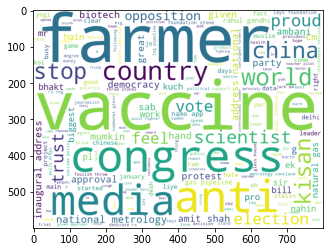

In [136]:
wc=WordCloud(
            height=600,width=800,
            stopwords=stop_word_combined,
            background_color='white')

wc.generate(modi)

plt.figure()
plt.imshow(wc)
plt.show()

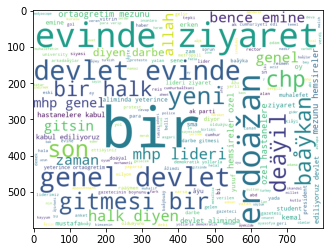

In [126]:
wc.generate(erdogan)

plt.figure()
plt.imshow(wc)
plt.show()

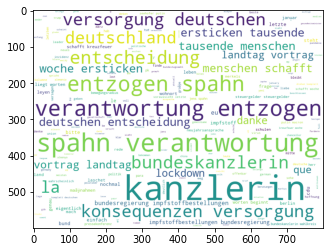

In [127]:
wc.generate(merkel)

plt.figure()
plt.imshow(wc)
plt.show()

In [137]:
#need to observe the word clouds and need to remove unneccasry words which appear often 
# after we remove unncessary words we'd be left with 'adjectives' which we can present to showcase what people are thinking